### 초보 농가가 사기 안 당하고 적절한 가격 낙찰받기

- 주제 : 소의 종류와 중량에 따른 낙찰가 예상 
- 데이터
    * 주요 특성 : 3개 => 종류, 중량, 최저가
- 주요학습
    * 지도학습 - 회귀
- 세부학습
    * KNeighborsRegressor 
    * LinearRegression
    * SVR 
    * DecisionTreeRegressor 
    * RandomForestRegressor => max_depth,n_estimators,min_samples_leaf,min_samples_split
- 교차검증 
    * gridsearchCV
    * Kfold
- 성능평가    
    * r2
    * rmse 

## [1] 탐색적 데이터 분석 진행

### [1-1] 데이터 준비

In [18]:
import pandas as pd
import numpy as np

In [19]:
# 파일 불러오기
filename='./data/cow_data.csv'
cow=pd.read_csv(filename)
cow.head(3)

,일자,번호,출하주,개체번호,성별,kpn,계대,중량,최저가,낙찰가,비고,결격사유 여부,종류,지역,Unnamed: 14
0,2021.07.23,1,서*호,48928970,암,550.0,3.0,580,360,363,목.배밑혹,1,큰소,경상남도 고성,NaN
1,2021.07.23,2,이*락,102112702,암,744.0,2.0,460,320,353,NaN,0,큰소,경상남도 고성,NaN
2,2021.07.23,3,문*종,156144852,암,1263.0,4.0,340,400,471,목이모색 상처,1,큰소,경상남도 고성,NaN


- 맨 마지막 컬럼을 성별(숫자) 암-0 수-1
- 큰 소 - 0 / 혈통 - 1 / 일반 - 2

In [20]:
# 성별과 종류 컬럼 임의의 정수 부여하기
cow['성별_Num']=cow['성별'].replace({'암':0,'수':1})
cow['종류_Num']=cow['종류'].replace({'큰소':0,'혈통우':1,'일반우':2})
cow.head(3)

,일자,번호,출하주,개체번호,성별,kpn,계대,중량,최저가,낙찰가,비고,결격사유 여부,종류,지역,Unnamed: 14,성별_Num,종류_Num
0,2021.07.23,1,서*호,48928970,암,550.0,3.0,580,360,363,목.배밑혹,1,큰소,경상남도 고성,NaN,0,0
1,2021.07.23,2,이*락,102112702,암,744.0,2.0,460,320,353,NaN,0,큰소,경상남도 고성,NaN,0,0
2,2021.07.23,3,문*종,156144852,암,1263.0,4.0,340,400,471,목이모색 상처,1,큰소,경상남도 고성,NaN,0,0


In [21]:
# 필요 컬럼만 추출
cow=cow[['성별_Num','종류_Num','중량','최저가','결격사유 여부','낙찰가']]
cow.info()  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17448 entries, 0 to 17447
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   성별_Num   17448 non-null  int64
 1   종류_Num   17448 non-null  int64
 2   중량       17448 non-null  int64
 3   최저가      17448 non-null  int64
 4   결격사유 여부  17448 non-null  int64
 5   낙찰가      17448 non-null  int64
dtypes: int64(6)
memory usage: 818.0 KB


In [22]:
cow.describe()   

,성별_Num,종류_Num,중량,최저가,결격사유 여부,낙찰가
count,17448.000000,17448.000000,17448.000000,17448.000000,17448.000000,17448.000000
mean,0.169704,1.125917,499.346114,669.672513,0.112391,5122.761692
std,0.375384,0.857750,173.233963,297.998572,0.315856,5350.663271
min,0.000000,0.000000,110.000000,0.000000,0.000000,57.000000
25%,0.000000,0.000000,310.000000,410.000000,0.000000,460.000000
50%,0.000000,1.000000,545.000000,560.000000,0.000000,636.000000
75%,0.000000,2.000000,634.000000,980.000000,0.000000,10950.000000
max,1.000000,2.000000,1114.000000,1250.000000,1.000000,14250.000000


### [1-2] 이상치 확인

In [23]:
# 최저가 0인 행 삭제
idx=cow[cow['최저가']==0].index
print(len(idx))
cow.drop(idx,inplace=True)

2


In [24]:
# 낙찰가 단위 다른것 변경
cow['낙찰가']=cow['낙찰가'].apply(lambda x: int(x/10) if x>2000 else int(x))

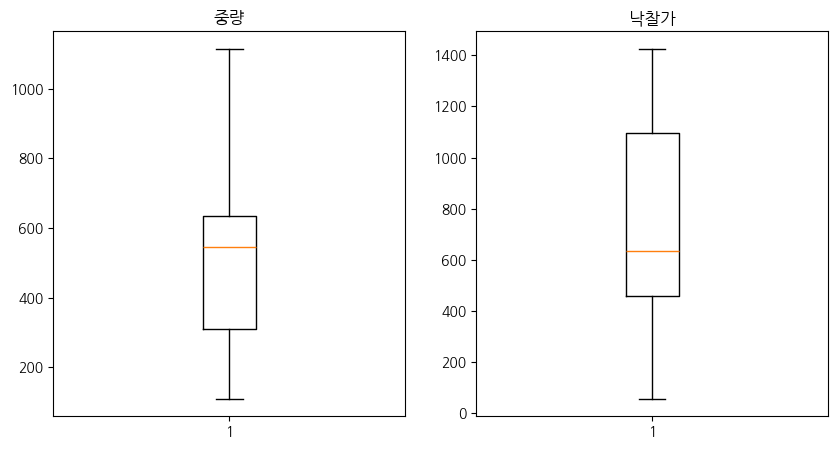

중량 => 하위 이상치 값: -176.0, 상위 이상치 값: 1120.0
상위 이상치 개수: 0, 하위 이상치 개수: 0
이상치: []
--------------------------------------------------------------------------------
낙찰가 => 하위 이상치 값: -492.5, 상위 이상치 값: 2047.5
상위 이상치 개수: 0, 하위 이상치 개수: 0
이상치: []
--------------------------------------------------------------------------------


In [25]:
# 시각화로 이상치 확인
import matplotlib.pyplot as plt
import matplotlib
import koreanize_matplotlib
matplotlib.rcParams['axes.unicode_minus'] = False

#이상치 박스플롯 확인 모듈-------------------------------------------------------------------------------------------
def boxplot_fliers_show(df,threshold): 
    '''
    컬럼별 박스 플롯 보여주기
    threshold : 임계값 (사분위수면 주로 1.5 같은)
    '''
    # 박스플롯
    fig, axes = plt.subplots(nrows=1, ncols=df.shape[1], figsize=(10, 5))
    for i in range(0, df.shape[1]):
        box_dict=axes[i].boxplot(df.iloc[:,i],whis=threshold)
        axes[i].set_title(df.columns[i])
    plt.show()

    # 이상치 개수와 이상치
    for column in df.columns:
        q1 = df[column].quantile(0.25)
        q3 = df[column].quantile(0.75)
        iqr = q3 - q1
        lower_iqr = q1 - (threshold * iqr)
        upper_iqr = q3 + (threshold * iqr)
        # 상위 이상치 데이터 추출
        upper_outlier = (df[column] > upper_iqr).sum()
        # 하위 이상치 데이터 추출
        lower_outlier = (df[column] < lower_iqr).sum()
        print(f'{column} => 하위 이상치 값: {lower_iqr}, 상위 이상치 값: {upper_iqr}')
        print(f'상위 이상치 개수: {upper_outlier}, 하위 이상치 개수: {lower_outlier}')
        print("이상치:",box_dict["fliers"][0].get_data()[1])
        print('-'*80)

# IQR 1.5배 이상을 이상치로 간주
boxplot_fliers_show(cow[['중량','낙찰가']],1.5)

박스플롯으로 이상치 확인해 본 결과 그냥 안고감~

In [27]:
# 낙찰가 기준으로 상관계수 확인
cow.corr()['낙찰가']

성별_Num    -0.326336
종류_Num     0.805461
중량         0.743921
최저가        0.982841
결격사유 여부   -0.117345
낙찰가        1.000000
Name: 낙찰가, dtype: float64

c:\Users\KDP-13\AppData\Local\anaconda3\envs\BY_YUNA_copy\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\KDP-13\AppData\Local\anaconda3\envs\BY_YUNA_copy\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\KDP-13\AppData\Local\anaconda3\envs\BY_YUNA_copy\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\KDP-13\AppData\Local\anaconda3\envs\BY_YUNA_copy\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_d

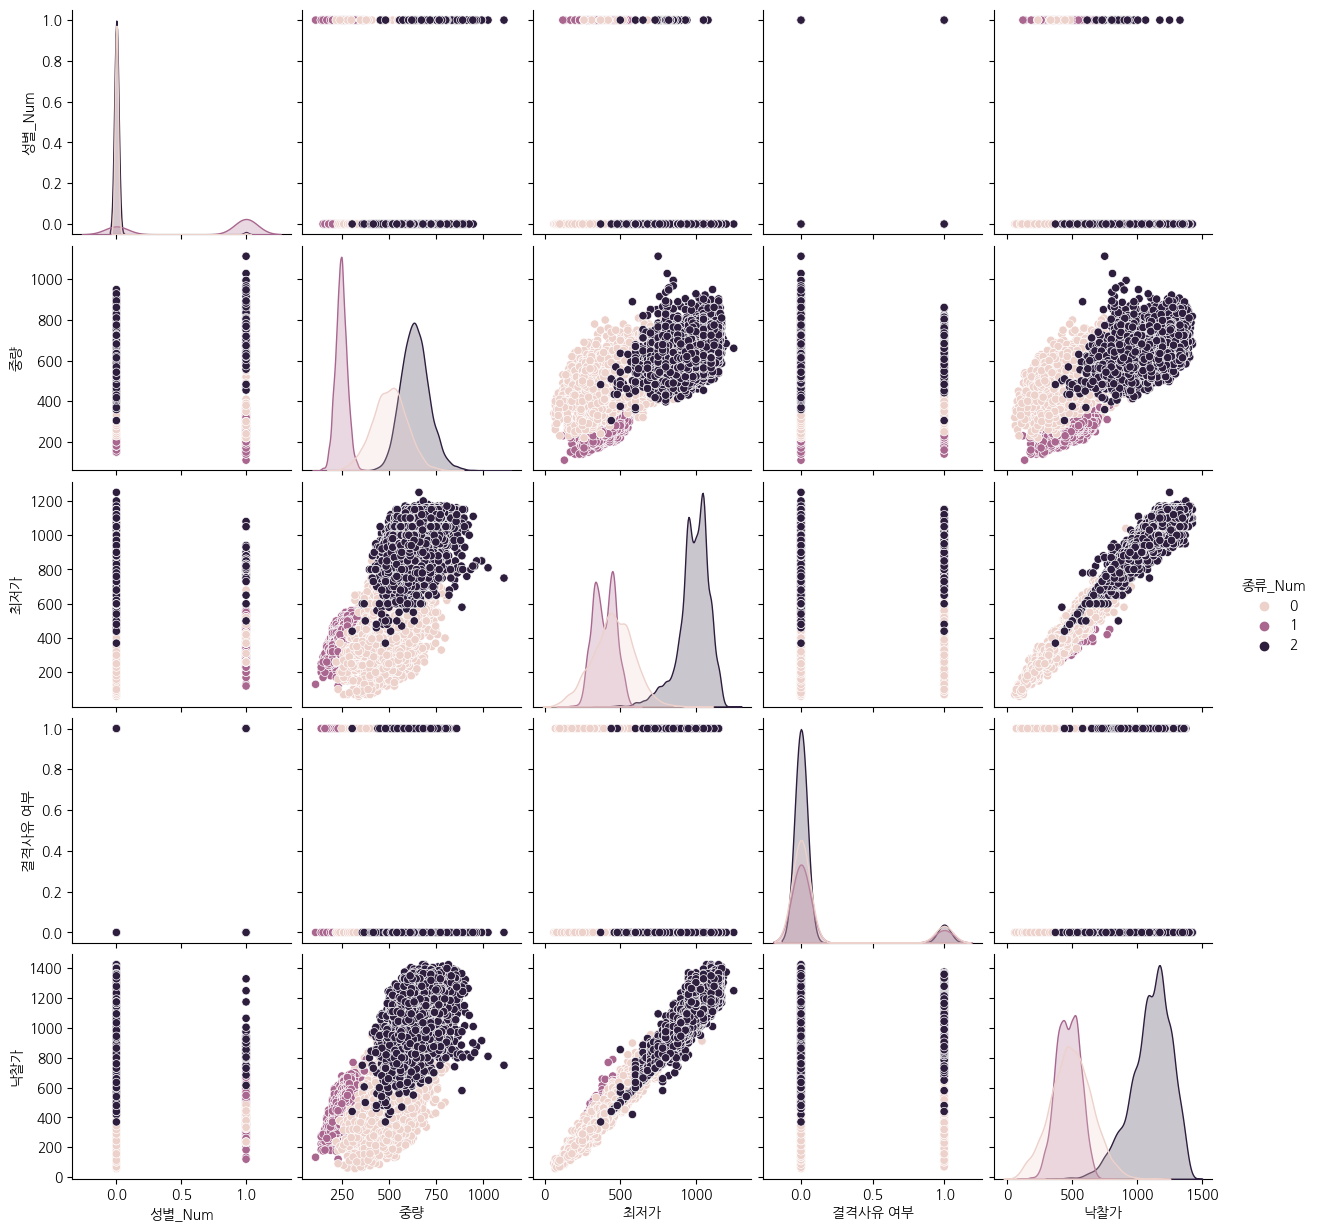

In [29]:
import koreanize_matplotlib
import seaborn as sns
import matplotlib.pyplot as plt

sns.pairplot(cow, hue='종류_Num')
plt.show()

피쳐 데이터와 타겟 데이터 분류

In [30]:
feature=cow[['종류_Num','중량','최저가']]
target=cow['낙찰가']
feature.shape,target.shape

((17446, 3), (17446,))

훈련용 데이터, 검증용 데이터, 테스트 데이터 분리

In [31]:
from sklearn.model_selection import train_test_split

In [32]:
# 훈련용 : 테스트용
trainx,test_X,trainy,test_y=train_test_split(feature,target,random_state=0,test_size=0.2,stratify=feature['종류_Num'])

# 훈련용 : 검증용
train_X,val_X,train_y,val_y=train_test_split(trainx,trainy,random_state=0,test_size=0.2,stratify=trainx['종류_Num'])

특성 피쳐에 대한 스케일링 진행

In [33]:
from sklearn.preprocessing import StandardScaler
scaler1=StandardScaler()
scaler1.fit(train_X)
train_x=scaler1.transform(train_X)
test_x=scaler1.transform(test_X)
val_x=scaler1.transform(val_X)

## [2] 모델 구현 상세 설계

In [35]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV,KFold

### [2-1] 학습 및 평가

In [36]:
trainModels=[LinearRegression(), KNeighborsRegressor(),SVR(),RandomForestRegressor(), DecisionTreeRegressor()]

In [37]:
def mL_score_print(trainModels,train_X,test_X,train_Y,test_Y):
    for model in trainModels:       
        model_ = model
        model_.fit(train_X,train_Y)
        train_score=model_.score(train_X,train_Y)
        test_score=model_.score(test_X,test_Y)
        print(f"{model.__class__.__name__} \ntrain_score : {train_score:.4f}, test_score : {test_score:.4f}")

In [38]:
mL_score_print(trainModels,train_x,test_x,train_y,test_y)

LinearRegression 
train_score : 0.9666, test_score : 0.9660
KNeighborsRegressor 
train_score : 0.9775, test_score : 0.9668
SVR 
train_score : 0.9607, test_score : 0.9614
RandomForestRegressor 
train_score : 0.9864, test_score : 0.9644
DecisionTreeRegressor 
train_score : 0.9883, test_score : 0.9546


### [2-2]  교차검증

In [39]:
# 점수가 높은 RandomForestRegressor 의 최적의 파라미터 찾기
grid_Models = [RandomForestRegressor()]

params={'RandomForestRegressor':{'max_depth':[5,10,15,25],
                                'n_estimators':[10,50,100,300],
                                'min_samples_leaf' : [12,18,24],
                                'min_samples_split' : [6,12,18]}}


In [40]:
def ml_GridSearchCV(grid_Models,params_,n_splits_,train_X,train_Y):
    '''
    GridSearchCV 이용해서 하이퍼파라미터 찾고 객체 반환
    n_splits_ :KFold의 n_splits
    '''
    grid_Dict={}
    kf=KFold(n_splits=n_splits_,shuffle=True,random_state=0)
    for model in grid_Models:
        model_name = model.__class__.__name__
        if model_name in params_.keys():
            param_grid_ = params_[model_name]
            gridCV = GridSearchCV(model, param_grid=param_grid_,cv=kf)
            gridCV.fit(train_X, train_Y)
        
            grid_Dict[gridCV.best_estimator_]=[gridCV.best_params_,gridCV.best_score_]
    return grid_Dict

In [41]:
grid_Dict=ml_GridSearchCV(grid_Models,params,10,train_x,train_y)


In [44]:
best_list = list(grid_Dict.keys())
best_list

# => 결과 RandomForestRegressor(max_depth=10, min_samples_leaf=18, min_samples_split=12,n_estimators=300)

[RandomForestRegressor(max_depth=10, min_samples_leaf=24, min_samples_split=6,
                       n_estimators=300)]

In [45]:
best_list=[RandomForestRegressor(max_depth=10, min_samples_leaf=18, min_samples_split=12,n_estimators=300)]

In [46]:
# 점수 확인
mL_score_print(best_list,train_x,test_x,train_y,test_y)

RandomForestRegressor 
train_score : 0.9741, test_score : 0.9715


## [3] 예측

In [47]:
from sklearn.metrics import mean_squared_error, r2_score

In [48]:
pre_y=best_list[0].predict(val_x)

In [49]:
r2=r2_score(val_y, pre_y) # 1에 가까울 수록 성능 좋음
mse=mean_squared_error(val_y, pre_y) 

In [50]:
print("성능평가")
print(f"r2 : {round(r2, 3)}")
print(f"RMSE : {round(np.sqrt(mse), 1)}")

성능평가
r2 : 0.972
RMSE : 56.8


## 서비스 제공

In [51]:
def cow_price_predict():
    try:
        kind=int(input('소의 종류 : 큰소 - 0 / 혈통우 - 1 / 일반우 - 2  =>'))
        weight=int(input('소의 무게 =>'))
        lower_price=int(input('최저가 =>'))
        new_data=pd.DataFrame([[kind,weight,weight]],columns=['종류_Num','중량','최저가'])
        new_data_=scaler1.transform(new_data)
        print(f' 중량 {weight}kg, 최저가 {lower_price}인 나의 소는 예상 낙찰가는 {best_list[0].predict(new_data_)[0]:.1f}(+-{round(np.sqrt(mse), 1)})만원이다')
    except:
        print('다시 입력하세요')
        pass

In [53]:
cow_price_predict()

 중량 680kg, 최저가 1000인 나의 소는 예상 낙찰가는 776.3(+-56.8)만원이다
